# TFF Energy Consumption

Combines both MF and NF systems

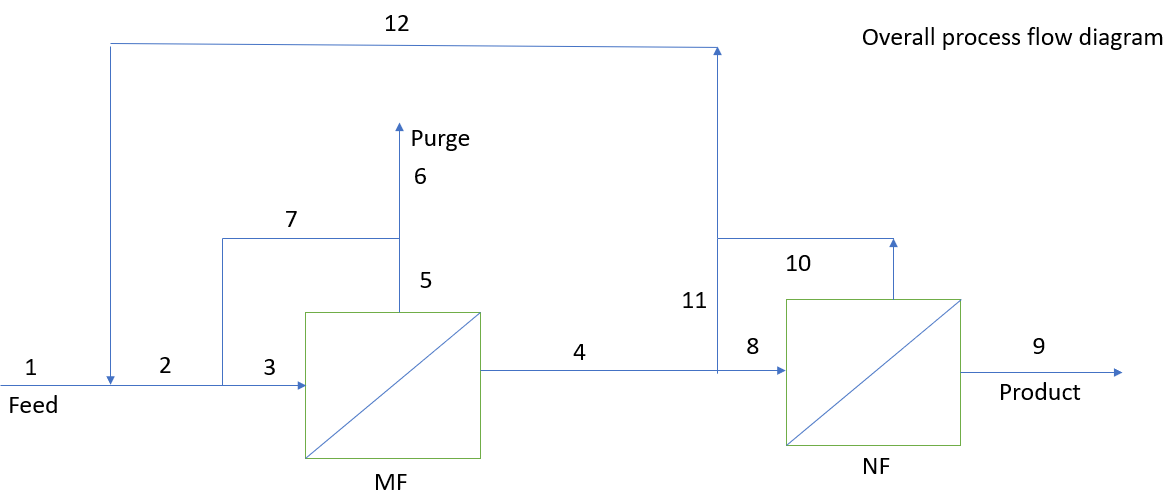

In [4]:
#Import Packages and Libraries
import numpy as np
import math as m
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as optimize
idx = pd.IndexSlice

#Adjusts window size for Jupyter notebook to fill screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
#Inputs
ID = .002  #Module inner diameter, m                                
length = 10  #Module length, m                              
numChannels = 163 #Number of channels in module                          
areaMod = numChannels*length*ID*3.14159 #Module area, m^2
eta = .00001 #Pipe roughness, m
FeedQ = (10000)/(1000*3600) #Feed to whole system flowrate, m^3/s (L/hr)  
MFflux = 17.4 #MF average flux, LMH
NFflux = 11.4 #NF average flux, LMH
gammaMF = 1000 #Desired shear rate for MF stage, 1/s
gammaNF = 2700 #Desired shear rate for NF stage, 1/s

In [7]:
#Build dataframes for output data
colsS = ['VR_NF','S1', 'S2', 'S3', 'S4', 'S5','S6','S7','S8','S9','S10','S11','S12'] #Stream Flowrates, L/hr
dfS = pd.DataFrame(data=np.zeros((100, len(colsS))), columns = colsS)

colsE = ['Kprime NF','Kprime MF','Re_NF','Re_MF','f_NF','f_MF','Pdrop NF Pa','Pdrop MF Pa'] #Reynolds number, friction factor, pressure drops for MF and NF
colsE2 = ['VR_NF','VR_O','P NF W','P MF W','kWh/m3 NF','kWh/m3 MF'] #Energy Requirements for MF and NF
dfE = pd.DataFrame(data=np.zeros((100, len(colsE))), columns = colsE)
dfE2 = pd.DataFrame(data=np.zeros((100, len(colsE2))), columns = colsE2)

colsA = ['VR_NF','VR_O','Area NF','Area MF','Visc NF Pa s','Visc MF Pa s','Density NF kg/m3','Density MF kg/m3'] #Area, viscosity, density data for MF and NF
dfA = pd.DataFrame(data=np.zeros((100, len(colsA))), columns = colsA)

colsC = ['VR_NF','VR_O','MF Mem $/L Cer','MF Mem $/L Pol','NF Mem $/L Cer','NF Mem $/L Pol','NF Energy $/L','MF Energy $/L','Tot Energy $/L'] #All cost data for MF and NF
dfC = pd.DataFrame(data=np.zeros((100, len(colsC))), columns = colsC)

#Begin iteration across NF VRs (1-100%)
for VolRec in range(1,101,1):
    VR = VolRec
    VR_M = 0.95 #Volume recovery of MF step
    VR_N = VR/100 #Volume recovery of NF step

#Mass balance to determine stream flowrates
    S1 = 10000 #L/hr
    def StreamSolve(S12):
        return (1-VR_N)*(VR_M*(S1+S12))-S12
    s0 = 8000
    s1 = 9000
    s = optimize.root_scalar(StreamSolve,method = 'secant', x0 = s0, x1 = s1)
    S12 = s.root
    S2 = S1+S12
    S4 = VR_M*S2
    S6 = S2-S4
    S9 = VR_N*S4
    
    VR_O = S9/S1 #Overall process volume recovery
    
    #Calculate required areas
    areaMF = S4/MFflux #Required area for MF stage, m^2
    numModMF = areaMF/areaMod #Number of modules required for MF stage
    areaNF = S9/NFflux #Required area for NF stage, m^2
    numModNF = areaNF/areaMod #Number of modules required for NF stage
    
    #Calculate density and viscosity
    #MF
    if VR_M < 0.88:
        n_MF = .962
        K_MF = 0.00001157*(VR_M*100) + 0.00151
        density_MF = 1054.73+0.000003667*(VR_M*100)**3.924 #MF retenate density, kg/m^3
    else:
        n_MF = -0.1298*(VR_M*100)+12.953 
        K_MF = 3e-50*np.exp(1.2033*(VR_M*100)) 
        density_MF = 1054.73+0.000003667*(VR_M*100)**3.924
    
    visc_MF = K_MF*gammaMF**(n_MF-1) #MF retentate viscosity, Pa s

    #NF
    n_NF = 0.962 
    K_NF = 0.00001157*(VR_N*100) + 0.00151
    density_NF = 1033.61 + .000003667*(VR_N*100)**3.85 #NF retentate density, kg/m^3
    visc_NF = K_NF*gammaNF**(n_NF-1) #NF retentate viscosity, Pa s

    #Calculate recirculation flow rates
    v_MF = (gammaMF*ID/8)*(4*n_MF/(1+3*n_MF)) #Cross sectional velocity, m/s
    Q_MF = v_MF*3.14159*(ID/2)**2 #Volumetric flow rate in a single channel, m^3/s
    TotalQ_MF = Q_MF*numChannels*numModMF #Total volumetric flow rate into the module, m^3/s
    S7 = TotalQ_MF*1000*3600 - S2 #L/hr
    S3 = TotalQ_MF*1000*3600 #L/hr
    S5 = S6 + S7 #L/hr

    v_NF = (gammaNF*ID/8)*(4*n_NF/(1+3*n_NF)) #Cross sectional velocity, m/s
    Q_NF = v_NF*3.14159*(ID/2)**2 #Volumetric flow rate in a single channel, m^3/s
    TotalQ_NF = Q_NF*numChannels*numModNF #Total volumetric flow rate into the module, m^3/s
    S11 = TotalQ_NF*1000*3600 - S4 #L/hr
    if S11 <0:
        S11 = 0
    S8 = TotalQ_NF*1000*3600 #L/hr
    S10 = S11 + S12 #L/hr
    
    #Solve for the Energy Consumption
    #MF
    K_primeMF = K_MF*((1+3*n_MF)/(4*n_MF))**n_MF
    Re_MF = (ID**n_MF*v_MF**(2-n_MF)*density_MF)/(K_primeMF*8**(n_MF-1)) #Modified Reynolds number
    
    #Solve for fanning friction factor
    def fricfactorMF(f):
        return 4*m.log10(Re_MF*f**0.5)-0.4-f**-0.5
    f0 = .005
    f1 = .01
    fricMF = optimize.root_scalar(fricfactorMF,method = 'secant', x0 = f0, x1 = f1)
    f_MF = fricMF.root #MF friction factor
    
    #Calculate pressure drop
    Pdrop_MF = f_MF*2*(density_MF)*length*v_MF**2/ID #MF pressure drop through module, Pa
    eff = 0.6 #Pump efficiency
    P_MF = (S3/(1000*3600))*Pdrop_MF/eff #Pump power required, W
    TotalP_MF = P_MF/S9 #Pump power required, kWh/m^3 of permeate

    #NF
    K_primeNF = K_NF*((1+3*n_NF)/(4*n_NF))**n_NF
    Re_NF = (ID**n_NF*v_NF**(2-n_NF)*density_NF)/(K_primeNF*8**(n_NF-1)) #Modified Reynolds number
    
    #Solve for fanning friction factor
    def fricfactorNF(f):
        return 4*m.log10(Re_NF*f**0.5)-0.4-f**-0.5
    f0 = .005
    f1 = .01
    fricNF = optimize.root_scalar(fricfactorNF,method = 'secant', x0 = f0, x1 = f1)
    f_NF = fricNF.root #NF friction factor
    
    #Calculate pressure drop
    Pdrop_NF = f_NF*2*(density_NF)*length*v_NF**2/ID #NF pressure drop through module, Pa
    eff = 0.6 #Pump efficiency
    P_NF = (S8/(1000*3600))*Pdrop_NF/eff #Pump power required, W
    TotalP_NF = P_NF/S9 #Pump power required, kWh/m^3 of permeate
    
    TotEnergy = TotalP_MF + TotalP_NF #Total energy requirement, NF + MF
    
    #Calculate energy costs
    MF_ECost = (TotalP_MF*0.072*S4/1000)/S9 #MF energy cost, $/kg
    NF_ECost = (TotalP_NF*0.072*S9/1000)/S9 #NF energy cost, $/kg
    
    #Calculate membrane costs
    CostMFCer = (150/(30*350*24))*areaMF/S9 #$/L
    CostMFPol = (500/(30*350*24))*areaMF/S9 #$/L
    CostNFCer = (150/(30*350*24))*areaNF/S9 #$/L
    CostNFPol = (500/(30*350*24))*areaNF/S9 #$/L
    
    dfS.loc[idx[VolRec-1],idx['VR_NF']] = VR
    dfS.loc[idx[VolRec-1],idx['S1']] = S1
    dfS.loc[idx[VolRec-1],idx['S2']] = S2
    dfS.loc[idx[VolRec-1],idx['S3']] = S3
    dfS.loc[idx[VolRec-1],idx['S4']] = S4
    dfS.loc[idx[VolRec-1],idx['S5']] = S5
    dfS.loc[idx[VolRec-1],idx['S6']] = S6
    dfS.loc[idx[VolRec-1],idx['S7']] = S7
    dfS.loc[idx[VolRec-1],idx['S8']] = S8
    dfS.loc[idx[VolRec-1],idx['S9']] = S9
    dfS.loc[idx[VolRec-1],idx['S10']] = S10
    dfS.loc[idx[VolRec-1],idx['S11']] = S11
    dfS.loc[idx[VolRec-1],idx['S12']] = S12
    
    dfE.loc[idx[VolRec-1],idx['Kprime NF']] = K_primeNF
    dfE.loc[idx[VolRec-1],idx['Kprime MF']] = K_primeMF
    dfE.loc[idx[VolRec-1],idx['Re_NF']] = Re_NF
    dfE.loc[idx[VolRec-1],idx['Re_MF']] = Re_MF
    dfE.loc[idx[VolRec-1],idx['f_NF']] = f_NF
    dfE.loc[idx[VolRec-1],idx['f_MF']] = f_MF
    dfE.loc[idx[VolRec-1],idx['Pdrop NF Pa']] = Pdrop_NF
    dfE.loc[idx[VolRec-1],idx['Pdrop MF Pa']] = Pdrop_MF
    
    dfE2.loc[idx[VolRec-1],idx['VR_NF']] = VR
    dfE2.loc[idx[VolRec-1],idx['VR_O']] = VR_O*100
    dfE2.loc[idx[VolRec-1],idx['P NF W']] = P_NF
    dfE2.loc[idx[VolRec-1],idx['P MF W']] = P_MF
    dfE2.loc[idx[VolRec-1],idx['kWh/m3 NF']] = TotalP_NF
    dfE2.loc[idx[VolRec-1],idx['kWh/m3 MF']] = TotalP_MF
    
    dfA.loc[idx[VolRec-1],idx['VR_NF']] = VR
    dfA.loc[idx[VolRec-1],idx['VR_O']] = VR_O*100
    dfA.loc[idx[VolRec-1],idx['Area NF']] = areaNF
    dfA.loc[idx[VolRec-1],idx['Area MF']] = areaMF
    dfA.loc[idx[VolRec-1],idx['Visc NF Pa s']] = visc_NF
    dfA.loc[idx[VolRec-1],idx['Visc MF Pa s']] = visc_MF
    dfA.loc[idx[VolRec-1],idx['Density NF kg/m3']] = density_NF
    dfA.loc[idx[VolRec-1],idx['Density MF kg/m3']] = density_MF
    
    dfC.loc[idx[VolRec-1],idx['VR_NF']] = VR
    dfC.loc[idx[VolRec-1],idx['VR_O']] = VR_O*100
    dfC.loc[idx[VolRec-1],idx['MF Mem $/L Cer']] = CostMFCer
    dfC.loc[idx[VolRec-1],idx['MF Mem $/L Pol']] = CostMFPol
    dfC.loc[idx[VolRec-1],idx['NF Mem $/L Cer']] = CostNFCer
    dfC.loc[idx[VolRec-1],idx['NF Mem $/L Pol']] = CostMFPol
    dfC.loc[idx[VolRec-1],idx['NF Energy $/L']] = NF_ECost
    dfC.loc[idx[VolRec-1],idx['MF Energy $/L']] = MF_ECost
    dfC.loc[idx[VolRec-1],idx['Tot Energy $/L']] = NF_ECost + MF_ECost

In [8]:
pd.set_option('display.max_rows',None)
dfS

,VR_NF,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12
0,1.0,10000.0,168067.226891,358462.801825,159663.865546,198798.936279,8403.361345,190395.574935,16850.404598,1596.638655,158067.226891,0.000000,158067.226891
1,2.0,10000.0,144927.536232,309109.227661,137681.159420,171428.068241,7246.376812,164181.691429,29060.842713,2753.623188,134927.536232,0.000000,134927.536232
2,3.0,10000.0,127388.535032,271701.104568,121019.108280,150681.996288,6369.426752,144312.569537,38315.888163,3630.573248,117388.535032,0.000000,117388.535032
3,4.0,10000.0,113636.363636,242369.735325,107954.545455,134415.189871,5681.818182,128733.371689,45572.685164,4318.181818,103636.363636,0.000000,103636.363636
4,5.0,10000.0,102564.102564,218754.222652,97435.897436,121318.325217,5128.205128,116190.120088,51415.337108,4871.794872,92564.102564,0.000000,92564.102564
5,6.0,10000.0,93457.943925,199332.118772,88785.046729,110547.072043,4672.897196,105874.174847,56220.508800,5327.102804,83457.943925,0.000000,83457.943925
6,7.0,10000.0,85836.909871,183077.568314,81545.064378,101532.503937,4291.845494,97240.658443,60242.004422,5708.154506,75836.909871,0.000000,75836.909871
7,8.0,10000.0,79365.079365,169274.100862,75396.825397,93877.275465,3968.253968,89909.021497,63657.084038,6031.746032,69365.079365,0.000000,69365.079365
8,9.0,10000.0,73800.738007,157406.174971,70110.701107,87295.473864,3690.036900,83605.436964,66593.296401,6309.963100,63800.738007,0.000000,63800.738007
9,10.0,10000.0,68965.517241,147093.356611,65517.241379,81576.115232,3448.275862,78127.839370,69144.763696,6551.724138,62593.039558,3627.522317,58965.517241


In [9]:
pd.set_option('display.max_rows',None)
dfE

,Kprime NF,Kprime MF,Re_NF,Re_MF,f_NF,f_MF,Pdrop NF Pa,Pdrop MF Pa
0,0.001536,1.44894,1214.101212,4.894617,0.014630,0.404404,67558.251505,241150.252122
1,0.001548,1.44894,1204.938929,4.894617,0.014669,0.404404,67736.307721,241150.252122
2,0.001559,1.44894,1195.914071,4.894617,0.014707,0.404404,67913.688069,241150.252122
3,0.001571,1.44894,1187.023760,4.894617,0.014745,0.404404,68090.407887,241150.252122
4,0.001583,1.44894,1178.265263,4.894617,0.014784,0.404404,68266.484721,241150.252122
5,0.001594,1.44894,1169.635985,4.894617,0.014821,0.404404,68441.938248,241150.252122
6,0.001606,1.44894,1161.133462,4.894617,0.014859,0.404404,68616.790230,241150.252122
7,0.001618,1.44894,1152.755358,4.894617,0.014897,0.404404,68791.064477,241150.252122
8,0.001629,1.44894,1144.499453,4.894617,0.014935,0.404404,68964.786823,241150.252122
9,0.001641,1.44894,1136.363642,4.894617,0.014972,0.404404,69137.985106,241150.252122


In [10]:
pd.set_option('display.max_rows',None)
dfE2

,VR_NF,VR_O,P NF W,P MF W,kWh/m3 NF,kWh/m3 MF
0,1.0,15.966387,527.029570,40020.090295,0.330087,25.065214
1,2.0,27.536232,911.330641,34510.077863,0.330957,12.532607
2,3.0,36.305732,1204.709850,30333.699013,0.331824,8.355071
3,4.0,43.181818,1436.603112,27059.038324,0.332687,6.266304
4,5.0,48.717949,1624.974225,24422.516641,0.333547,5.013043
5,6.0,53.271028,1781.407681,22254.162360,0.334405,4.177536
6,7.0,57.081545,1913.709713,20439.445258,0.335259,3.580745
7,8.0,60.317460,2027.332672,18898.375973,0.336110,3.133152
8,9.0,63.099631,2126.200227,17573.397583,0.336959,2.785024
9,10.0,65.517241,2213.208168,16422.037052,0.337805,2.506521


In [11]:
pd.set_option('display.max_rows',None)
dfA

,VR_NF,VR_O,Area NF,Area MF,Visc NF Pa s,Visc MF Pa s,Density NF kg/m3,Density MF kg/m3
0,1.0,15.966387,140.056022,9176.084227,0.001127,0.097464,1033.610004,1266.029436
1,2.0,27.536232,241.545894,7912.710312,0.001136,0.097464,1033.610053,1266.029436
2,3.0,36.305732,318.471338,6955.121166,0.001144,0.097464,1033.610252,1266.029436
3,4.0,43.181818,378.787879,6204.284222,0.001153,0.097464,1033.610763,1266.029436
4,5.0,48.717949,427.350427,5599.764220,0.001161,0.097464,1033.611800,1266.029436
5,6.0,53.271028,467.289720,5102.588892,0.001170,0.097464,1033.613632,1266.029436
6,7.0,57.081545,500.715308,4686.497953,0.001178,0.097464,1033.616576,1266.029436
7,8.0,60.317460,529.100529,4333.150885,0.001187,0.097464,1033.620995,1266.029436
8,9.0,63.099631,553.505535,4029.350638,0.001195,0.097464,1033.627304,1266.029436
9,10.0,65.517241,574.712644,3765.358700,0.001204,0.097464,1033.635960,1266.029436


In [12]:
pd.set_option('display.max_rows',None)
dfC

,VR_NF,VR_O,MF Mem $/L Cer,MF Mem $/L Pol,NF Mem $/L Cer,NF Mem $/L Pol,NF Energy $/L,MF Energy $/L,Tot Energy $/L
0,1.0,15.966387,0.003421,0.011403,0.000052,0.011403,0.000024,0.180470,0.180493
1,2.0,27.536232,0.001710,0.005702,0.000052,0.005702,0.000024,0.045117,0.045141
2,3.0,36.305732,0.001140,0.003801,0.000052,0.003801,0.000024,0.020052,0.020076
3,4.0,43.181818,0.000855,0.002851,0.000052,0.002851,0.000024,0.011279,0.011303
4,5.0,48.717949,0.000684,0.002281,0.000052,0.002281,0.000024,0.007219,0.007243
5,6.0,53.271028,0.000570,0.001901,0.000052,0.001901,0.000024,0.005013,0.005037
6,7.0,57.081545,0.000489,0.001629,0.000052,0.001629,0.000024,0.003683,0.003707
7,8.0,60.317460,0.000428,0.001425,0.000052,0.001425,0.000024,0.002820,0.002844
8,9.0,63.099631,0.000380,0.001267,0.000052,0.001267,0.000024,0.002228,0.002252
9,10.0,65.517241,0.000342,0.001140,0.000052,0.001140,0.000024,0.001805,0.001829


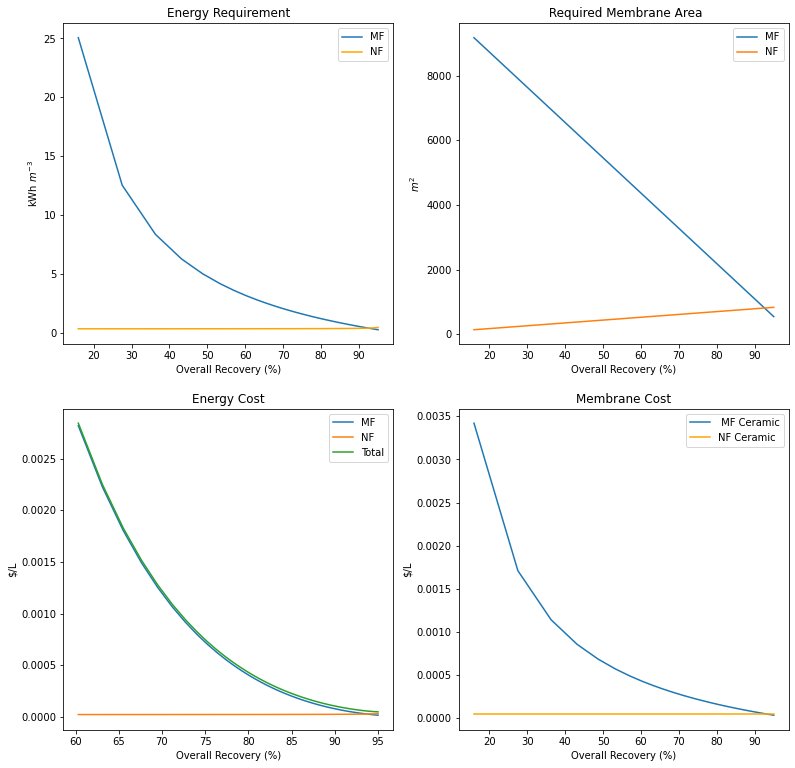

In [13]:
#Plot results
fig, ((fig1, fig2),(fig3, fig4)) = plt.subplots(2,2,sharey=False,figsize=(13,13))

fig1.plot(dfE2.loc[idx[:],idx['VR_O']],dfE2.loc[idx[:],idx['kWh/m3 MF']], label = 'MF' )
fig1.plot(dfE2.loc[idx[:],idx['VR_O']],dfE2.loc[idx[:],idx['kWh/m3 NF']],color = 'orange', label = 'NF' )
fig1.legend(fontsize=10)
fig1.set_xlabel('Overall Recovery (%)')
fig1.set_ylabel('kWh $ m^{-3} $')
fig1.set_title('Energy Requirement')

fig2.plot(dfA.loc[idx[:],idx['VR_O']],dfA.loc[idx[:],idx['Area MF']], label = 'MF')
fig2.plot(dfA.loc[idx[:],idx['VR_O']],dfA.loc[idx[:],idx['Area NF']], label = 'NF')
fig2.legend(fontsize=10)
fig2.set_xlabel('Overall Recovery (%)')
fig2.set_ylabel('$ m^{2} $')
fig2.set_title(' Required Membrane Area')

fig3.plot(dfC.loc[idx[7:],idx['VR_O']],dfC.loc[idx[7:],idx['MF Energy $/L']], label = 'MF')
fig3.plot(dfC.loc[idx[7:],idx['VR_O']],dfC.loc[idx[7:],idx['NF Energy $/L']], label = 'NF')
fig3.plot(dfC.loc[idx[7:],idx['VR_O']],dfC.loc[idx[7:],idx['Tot Energy $/L']], label = 'Total')
fig3.set_xlabel('Overall Recovery (%)')
fig3.legend(fontsize=10)
fig3.set_ylabel('$/L')
fig3.set_title('Energy Cost')

fig4.plot(dfC.loc[idx[:],idx['VR_O']],dfC.loc[idx[:],idx['MF Mem $/L Cer']], label = ' MF Ceramic')
fig4.plot(dfC.loc[idx[:],idx['VR_O']],dfC.loc[idx[:],idx['NF Mem $/L Cer']],color = 'orange', label = 'NF Ceramic')
fig4.set_xlabel('Overall Recovery (%)')
fig4.set_ylabel('$/L')
fig4.set_title('Membrane Cost')
fig4.legend(fontsize=10)